## **ALDANDI FITRA RAMADHAN HCK-004**

***Final Project***

---

***`Problem Statement`***

* **Memprediksi jumlah penjualan ParagonCorp sampai akhir tahun 2024**

`Objective`

* Setidaknya perusahaan ini bisa melakukan tindakan yang diperlukan untuk me-handling jika terjadinya penurunan pada prediksi ini.

# **`Import Library`**

In [386]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pylab
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
import warnings

# Ignore all warnings
warnings.simplefilter("ignore")

# **`Data Loading`**

In [387]:
# data loading
data = pd.read_csv('sample_dataset_timeseries_noarea.csv')

`Overview`

In [388]:
# display dimension
data.shape

(102733, 5)

In [389]:
# display top 5
data.head()

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [390]:
# display top 5 from bottom
data.tail()

,week_number,week_start_date,week_end_date,product_item,quantity
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


In [391]:
# display information about datasets
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


Dari informasi diatas dapat diketahui bahwa kolom kolom date masih object, maka akan diganti menjadi datetime untuk memudahkan EDA

**`Data Fixing`**

Terlihat bahwa beberapa datetime masih memiliki datatypes object, maka akan diubah datatypesnya

In [392]:
# changing datatypes
data['week_start_date'] = data['week_start_date'].astype('datetime64')
data['week_end_date'] = data['week_end_date'].astype('datetime64')

# **`Exploratory Data Analysis`**

`Jumlah product dalam datasets`

In [393]:
# count unique on product_item
data['product_item'].nunique()

2309

Jumlah Products pada perusahaan ParagonCorp yang terdata pada dataset ini adalah ***2390***

`Jumlah berapa minggu dalam datasets`

In [394]:
# count unique on week_end_date
data[['week_start_date','week_end_date']].nunique()

week_start_date    67
week_end_date      67
dtype: int64

Jumlah minggu pada dataset ini adalah 67 minggu, dimana ***mulai dari minggu pertama 2022 sampai minggu ke-14 2023***

`Jumlah quantity per product`

In [395]:
data.groupby('product_item')[['quantity']].sum().sort_values(by='quantity', ascending=False)

,quantity
product_item,
2949ca4cfbf13969bccfbb9817f2526a,18206376
2db7ed9bd7573aec037aac59237cb3dd,9122007
160eb16a7369a645ec75caa3f14543d4,6771207
229a936943f7da9feea525f1a48d1d03,6658518
0f9d1e065ad64ecd7237084107a4bfbd,4202082
...,...
3619fde2d22f364f14a595f2c7d95eb0,2
d79c7a64e815ebb411b976fc2444f750,2
3db6960af3e714e64aa08ee193515a62,2


Dapat diketahui diatas bahwa paling banyak product terjual adalah product 2949ca4cfbf13969bccfbb9817f2526a, dan yang paling sedikit terjual dalam 67 minggu terakhir adalah 91c30a9df505d481487e1d5099cc57dd

`Top 5 Product yang penjualan terbanyak selama 3 tahun terakhir`

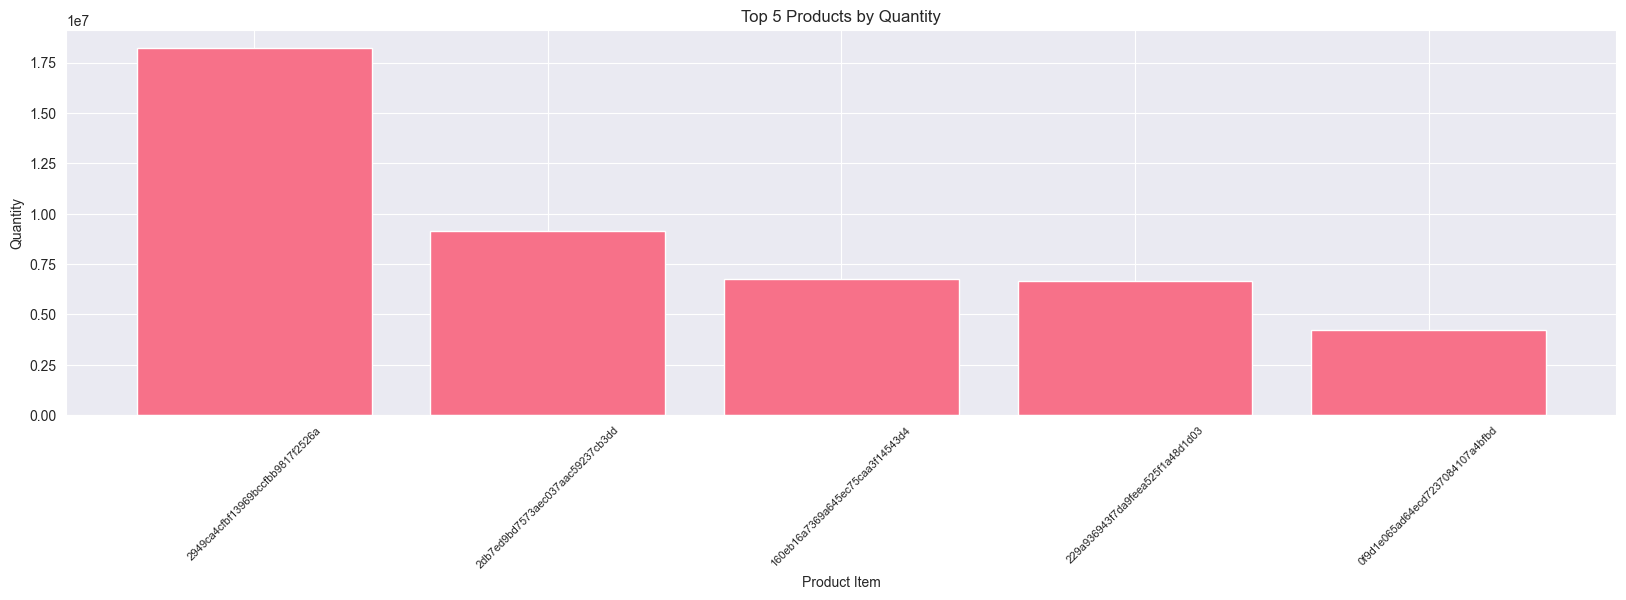

In [396]:
# Group the data by product_item and sum the quantity for each item
item_qty = data.groupby('product_item')['quantity'].sum().sort_values(ascending=False)[:5]

# Create a horizontal bar plot using matplotlib
fig, ax = plt.subplots()
ax.bar(item_qty.index, item_qty.values)

# Rotate the x-axis labels and set font size
plt.xticks(rotation=45, fontsize=8)

# Set the plot title and axis labels
plt.title('Top 5 Products by Quantity')
ax.set_xlabel('Product Item')
ax.set_ylabel('Quantity')

# Show the plot
plt.show()

Seperti yang dijelaskan sebelum cell ini, ini merupakan visualisasi dari 5 teratas penjualan tertinggi, dimana urutan ke 5 adalah 0f9d1e065ad64ecd7237084107a4bfbd

`Distribusi jumlah penjualan per minggu`

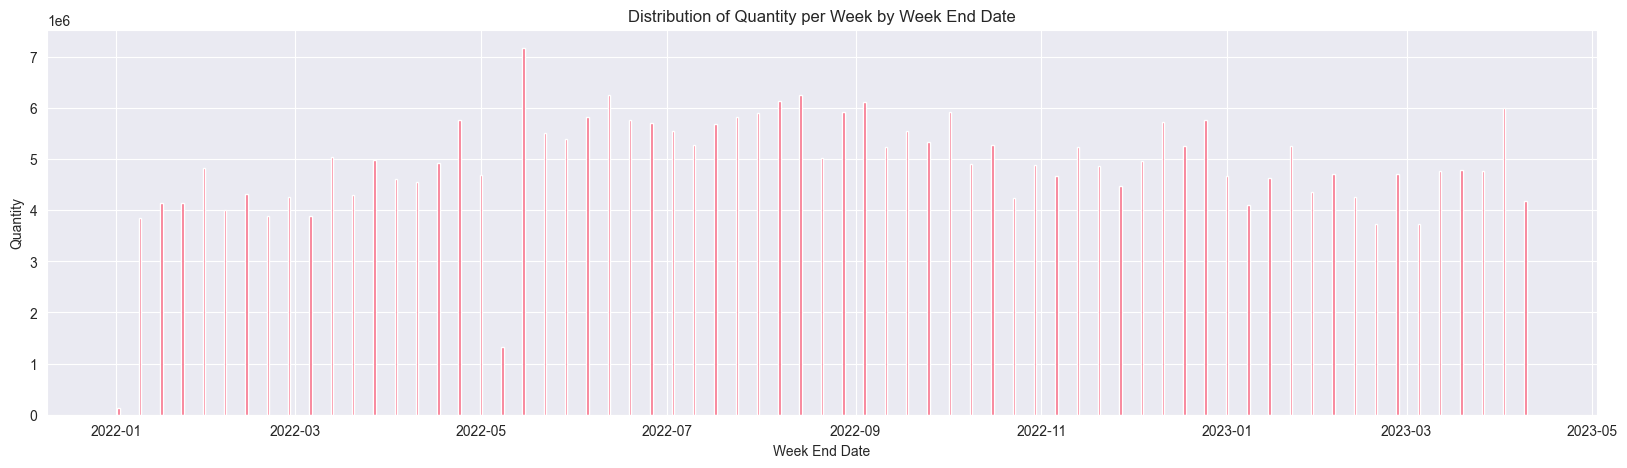

In [397]:
# Group the data by week_end_date and calculate the sum of quantity
grouped_data = data.groupby('week_end_date')['quantity'].sum().reset_index()

# Plot the data
plt.bar(grouped_data['week_end_date'], grouped_data['quantity'])
plt.title('Distribution of Quantity per Week by Week End Date')
plt.xlabel('Week End Date')
plt.ylabel('Quantity')
plt.show()

Ini merupakan distribusi penjualan tiap minggunya pada perusahaan ini yang bisa diketahui mempunyai distribusi yang normal berdasarkan setiap minggunya

`Minggu keberapa sampai minggu keberapa datasets Paragoncrop`

In [398]:
# week number
data['week_number'].unique()

array(['2021-52', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
       '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11',
       '2022-12', '2022-13', '2022-14', '2022-15', '2022-16', '2022-17',
       '2022-18', '2022-19', '2022-20', '2022-21', '2022-22', '2022-23',
       '2022-24', '2022-25', '2022-26', '2022-27', '2022-28', '2022-29',
       '2022-30', '2022-31', '2022-32', '2022-33', '2022-34', '2022-35',
       '2022-36', '2022-37', '2022-38', '2022-39', '2022-40', '2022-41',
       '2022-42', '2022-43', '2022-44', '2022-45', '2022-46', '2022-47',
       '2022-48', '2022-49', '2022-50', '2022-51', '2022-52', '2023-01',
       '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
       '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2023-13',
       '2023-14'], dtype=object)

Dapat diketahui dari diatas bahwa datasets ParagonCorp ini menyebut bahwa datasets ini dari minggu ke 52 tahun 2021 sampai minggu ke 14 tahun 2023

`Line Plot Distribusi per minggu`

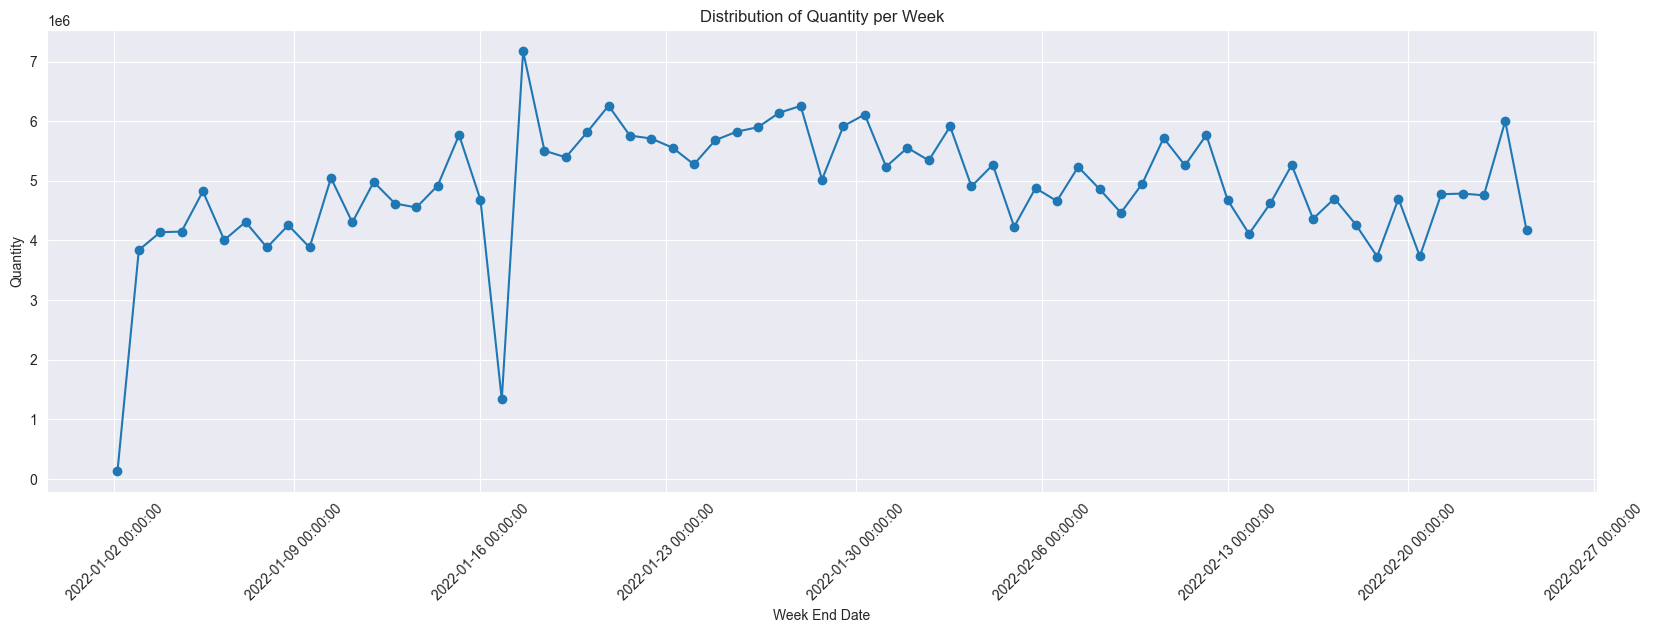

In [399]:
# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(20,6))

# Plot the data
ax.plot(grouped_data['week_end_date'], grouped_data['quantity'], color='tab:blue', marker='o')
ax.set_title('Distribution of Quantity per Week')
ax.set_xlabel('Week End Date')
ax.set_ylabel('Quantity')
ax.set_xticklabels(grouped_data['week_end_date'], rotation=45)
ax.grid(True)
plt.show()

Dari visualisasi diatas kita dapat ketahui bahwa terjadi kenaikan drastis di minggu pertama ke minggu ke-2. Selain itu, terjadi juga penurunan drastis pada tahun 2022-01-16

`Line Plot Distribusi per Bulan`

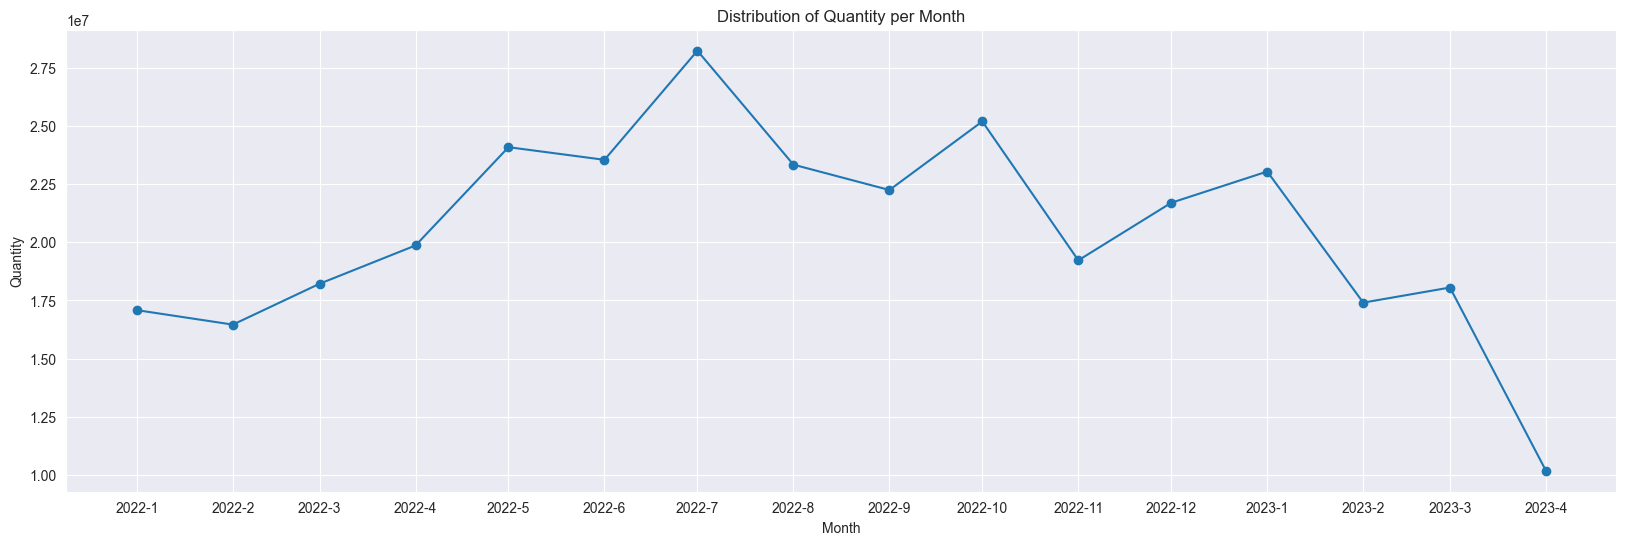

In [400]:
# Group the data by year and month and calculate the sum of quantity
grouped_data_monthly = data.groupby([data['week_end_date'].dt.year.rename('year'), data['week_end_date'].dt.month.rename('month')])['quantity'].sum().reset_index()

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(20,6))

# Plot the data as a line chart
ax.plot(grouped_data_monthly.apply(lambda x: pd.datetime(x['year'], x['month'], 1), axis=1), grouped_data_monthly['quantity'], color='tab:blue', marker='o')
ax.set_title('Distribution of Quantity per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Quantity')
ax.set_xticks(grouped_data_monthly.apply(lambda x: pd.datetime(x['year'], x['month'], 1), axis=1))
ax.set_xticklabels(grouped_data_monthly['year'].astype(str) + '-' + grouped_data_monthly['month'].astype(str))
ax.grid(True)
plt.show()


Visualiasi diatas adalah distribusi per bulan yang dapat menyimpulkan ternyata terjadi penurunan terus-menerus pada tahun 2023

`Distribusi Per tahun`

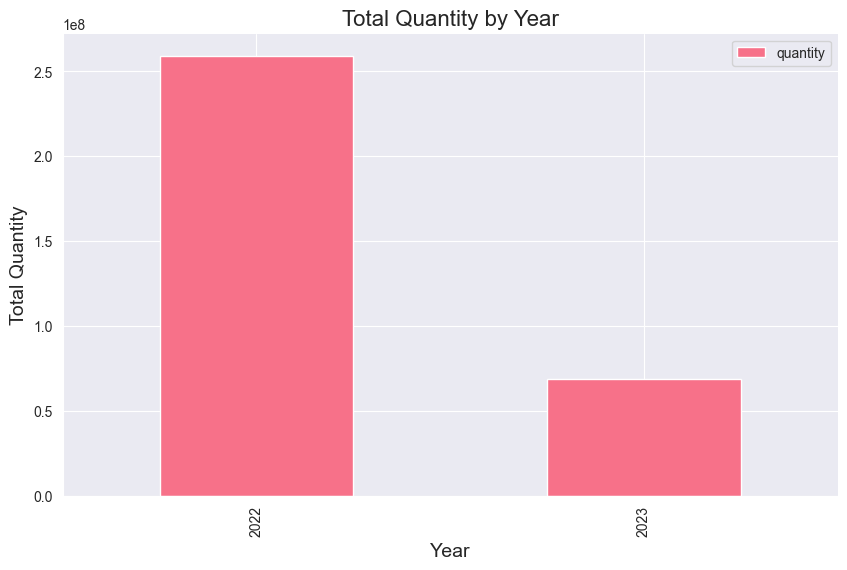

In [401]:
# Set the color palette
sns.set_palette('husl')
# Create a bar chart of the total quantity by year
ax = grouped_data_monthly.groupby('year')[['quantity']].sum().plot(kind='bar', figsize=(10, 6))

# Set the chart title and axis labels
ax.set_title('Total Quantity by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Quantity', fontsize=14)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

Terlihat memang dari sini penjualan 2022 berbeda drastis dengan 2023, itu juga dikarenakan memang dataset ini tahun 2022 full sedangkan 2023 hanya sampai minggu ke-14

`Data Cleaning`

In [402]:
# count missing value
data.isnull().sum()

week_number        0
week_start_date    0
week_end_date      0
product_item       2
quantity           0
dtype: int64

Dari informasi diatas dapat diketahui bahwa ada missing value pada kolom product_item

In [403]:
# count missing values in your column
missing_values = data['product_item'].isnull().sum()

# calculate the percentage of missing values in your column
total_values = len(data['product_item'])
percentage_missing = (missing_values / total_values) * 100

# print the result
print(f"Number of missing values in product_item: {missing_values}")
print(f"Percentage of missing values in product_item: {percentage_missing}%")

Number of missing values in product_item: 2
Percentage of missing values in product_item: 0.0019467941167881791%


Karena ada product yang merupakan `MISSING COMPLETELY AT RANDOM` yang dimana tidak ada informasi dari kolom lain atau luar dataset.

* Dikarenakan MCAR dan terdapat hanya 0.0019% dari total dataset maka baris tersebut akan di hapus

In [404]:
# trimming null values
df = data.copy()
df.dropna(inplace=True)

## Train Test Split

`prepare dataset`

Hanya menggunakan kolom `week_end_date` dan kolom `quantity`

In [405]:
# new variable for new data sorted date
df_main = df.groupby('week_end_date')[['quantity']].sum().reset_index().sort_values('week_end_date')

In [406]:
df_main

,week_end_date,quantity
0,2022-01-02,128808
1,2022-01-09,3839557
2,2022-01-16,4138934
3,2022-01-23,4149077
4,2022-01-30,4824273
...,...,...
62,2023-03-12,4775638
63,2023-03-19,4787111
64,2023-03-26,4757590
65,2023-04-02,6001166


In [407]:
# train-test split
train_size = int(len(df_main) * 0.8)
train_data = df_main[:train_size]
test_data = df_main[train_size:]

## **`EDA Modelling`**

**`Checking stationarity`**

In [408]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [409]:
check_stationarity(train_data['quantity'])

ADF Statistic: -7.196339
p-value: 0.000000
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597
Stationary


Dari hasil diatas dapat diketahui bahwa p-value < 0.05 dimana dapat dikatakan bahwa dataset sudah stationer. Dimana dapat disimpulkan kita bisa memakai model2 yang menggunakan asumsi stationary seperti ARIMA.

**`Decompose`**

In [410]:
#Start to decompose
pylab.rcParams['figure.figsize'] = (20, 6)
#We try to look at the data in yearly period, since the data are in monthly period, we aggregate it into 12 period
res = seasonal_decompose(train_data['quantity'],model='additive', period=4)

`Trend Decompose Visualize`

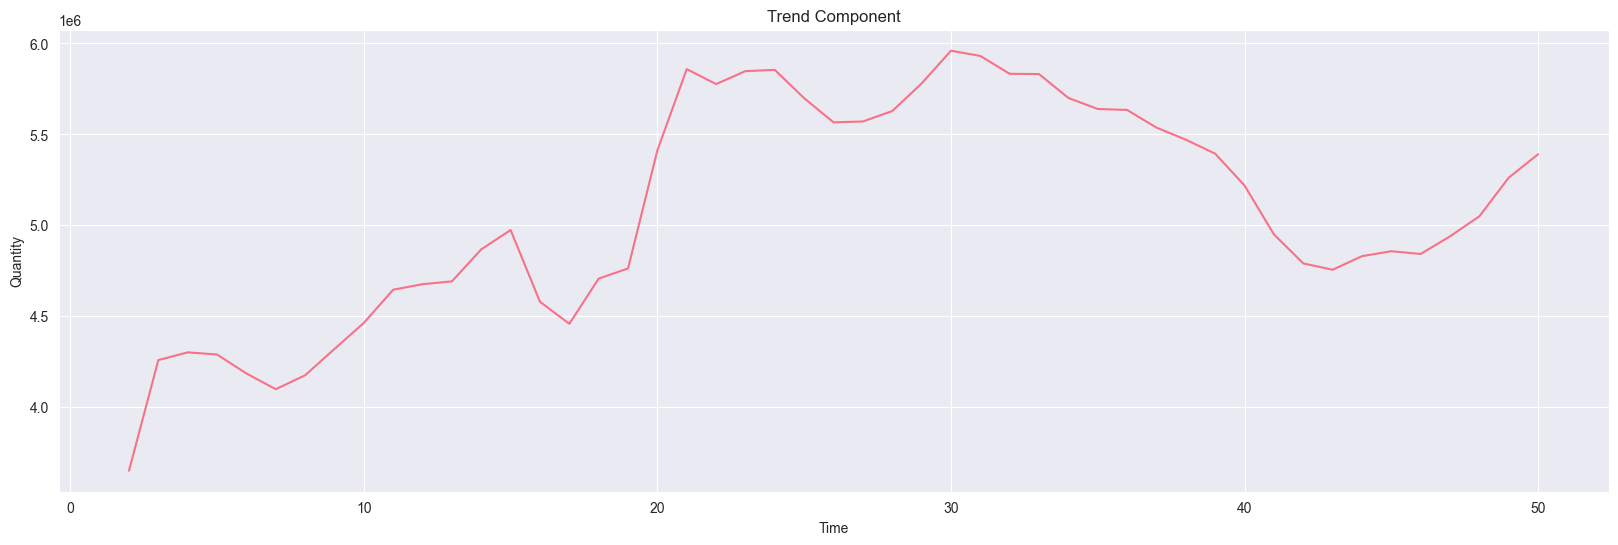

In [411]:
# Access the trend component
trend = res.trend

# Plot the trend component
plt.plot(trend)
plt.title('Trend Component')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.show()

Dapat diketahui bahwa terjadi trend kenaikan dari minggu ke-5 hingga minggu ke 11 dan terjadi penurunan dari minggu ke 24 sampai minggu ke-35

`Seasonal Decompose Visualize`

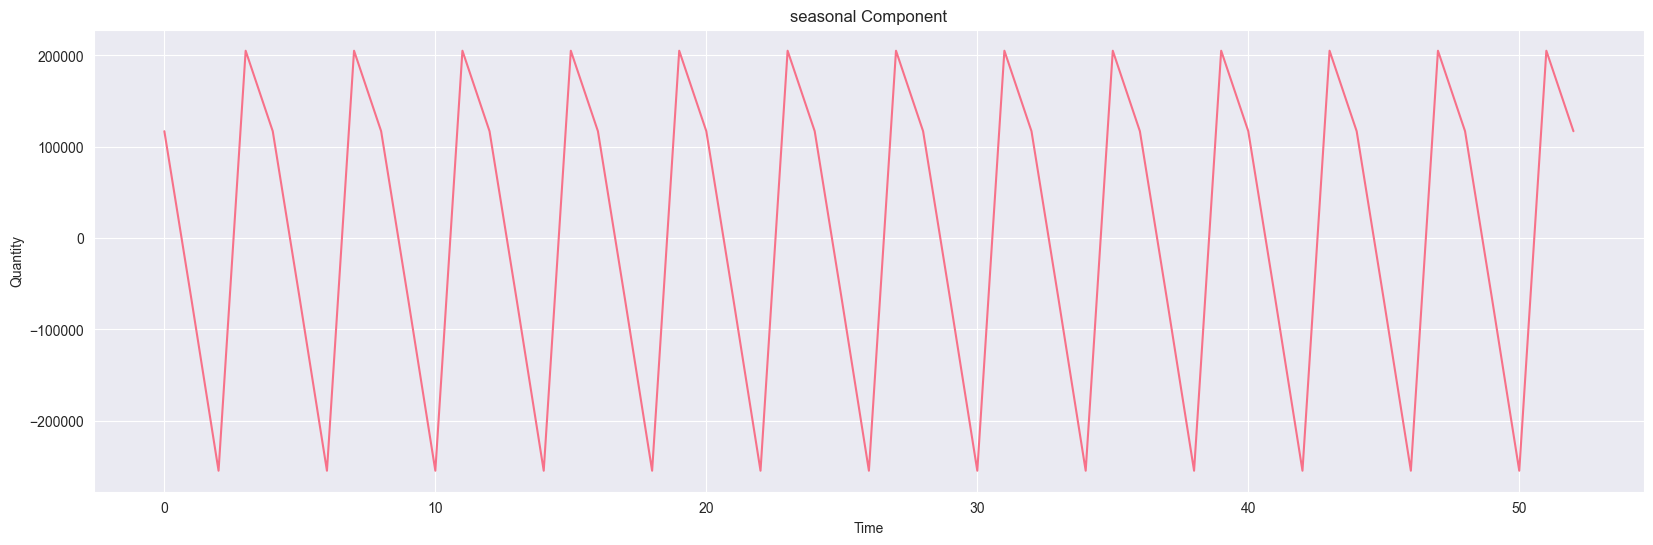

In [412]:
# Access the seasonal component
seasonal = res.seasonal

# Plot the seasonal component
plt.plot(seasonal)
plt.title('seasonal Component')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.show()

Dapat disimpulkan bahwa terjadi kenaikan dan penurunan setiap 4 period. Ini akan dijadikan untuk seasonal_period untuk model SARIMAX

`Resid Decompose Visualize`

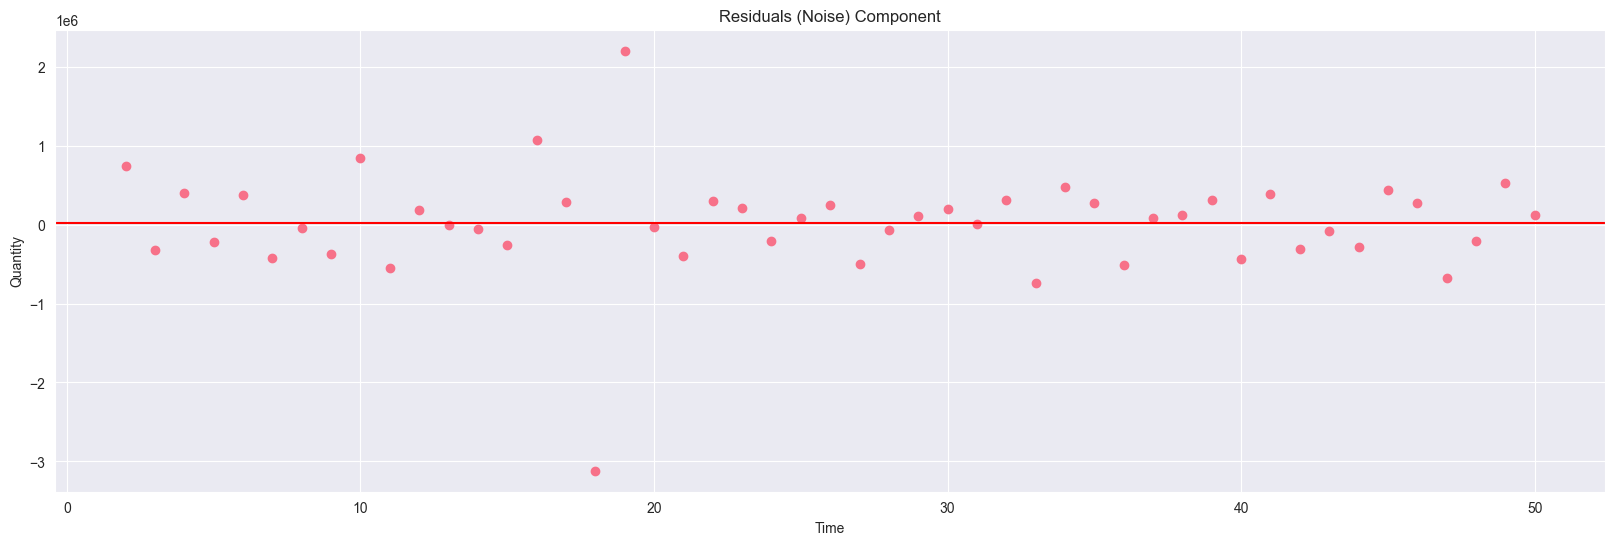

In [413]:
# Access the residuals (noise) component
residuals = res.resid

# Calculate the mean of the residuals
mean_residuals = np.mean(residuals)

# Plot the residuals (noise) component as a scatter plot with a middle line
plt.scatter(residuals.index, residuals)
plt.axhline(y=mean_residuals, color='r', linestyle='-')
plt.title('Residuals (Noise) Component')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.show()

Dapat diketahui bahwa terdapat noise yang terjadi pada 2022-01-16 yang sudah dijelaskan di EDA

**`Autocorrelation and Partial Autocorrelation`**

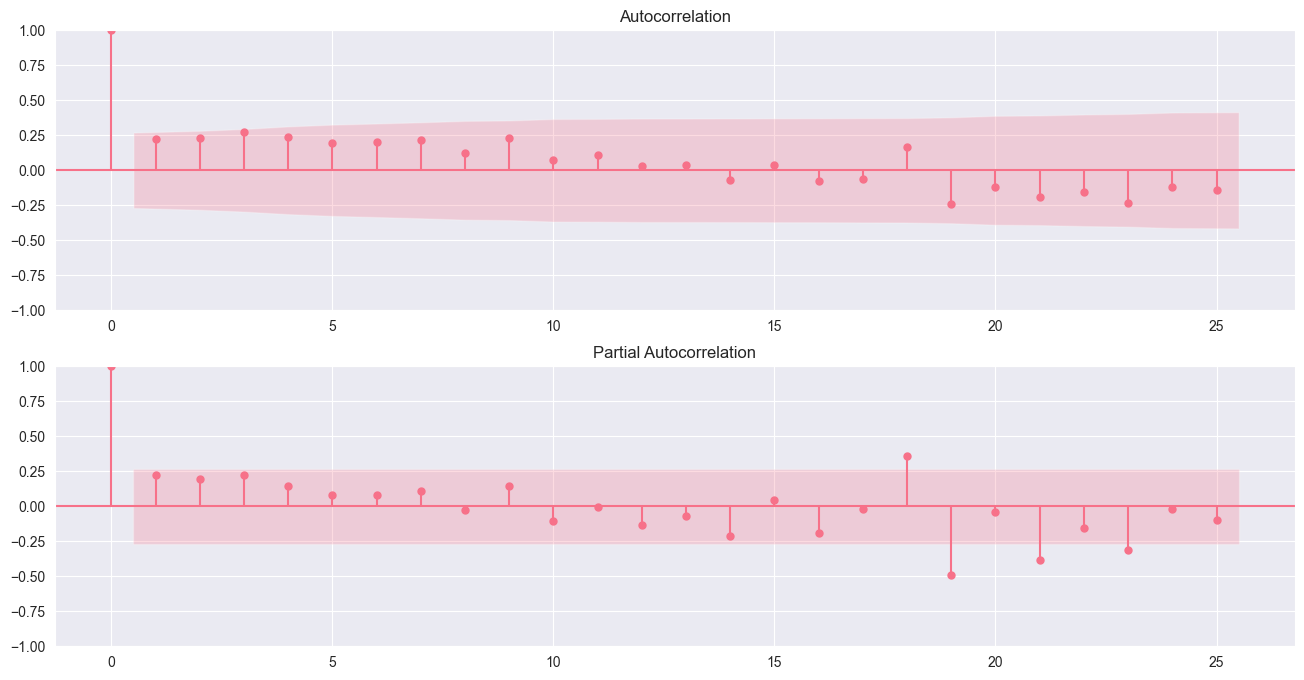

In [415]:
# display Autocorrelation and Partial Autocorrelation
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(train_data['quantity'], lags=25, ax=ax[0])
plot_pacf(train_data['quantity'], lags=25, ax=ax[1])

plt.show()


Dapat diketahui bahwa terjadi autocorrelation sedikit pada lags index ke-3 dan terjadi PartialAutocorrelation pada lags index ke 19. Dimana 19 akan menjadi AR dan 3 akan menjadi MA. Untuk order terbaik untuk model ARIMA

# **`Modelling`**

Saya akan melakukan training beberapa Model, diantaranya
* ARIMA
* SARIMAX
* Holt-Winter
* LSTM

# **` USING ARIMA`**

`Define`

In [416]:
# Build the ARIMA model with (p,d,q) parameters = (19,1,3)
model_ar = sm.tsa.ARIMA(train_data['quantity'], order=(19,1,3))

`Training`

In [417]:
# Fit the model to the data
fitted_model = model_ar.fit()

`Predict`

In [418]:
# Use the fitted model to make predictions on the test data
predictions_ar = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True)

## **`Evaluation for ARIMA`**

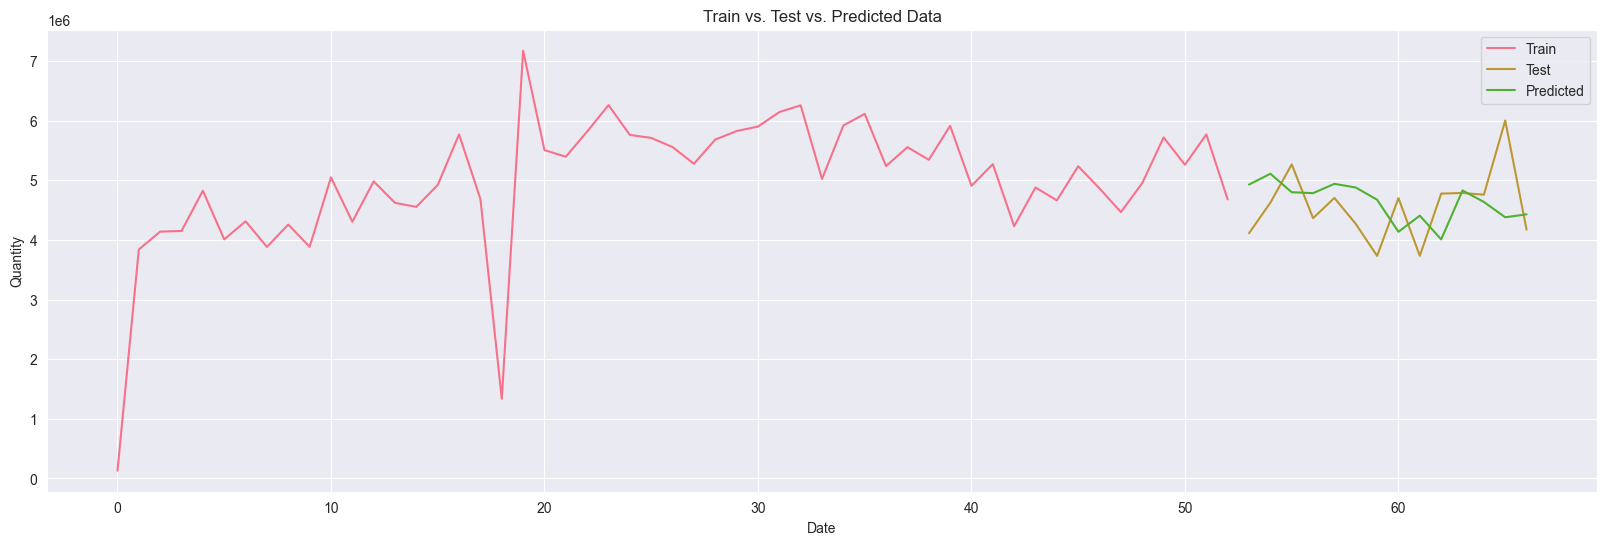

In [420]:
# Plot the train, test, and predicted data
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(test_data.index, predictions_ar, label='Predicted')
plt.title('Train vs. Test vs. Predicted Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [421]:
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data['quantity'], predictions_ar)

print('MAPE:', mape)

MAPE: 0.125793838332057


Evaluation for ARIMA :
* Dapat diketahui dari visualisasi bahwa model ini memperlihatkan kinerja yang baik dimana pada predicted data mengikuti trend pada test data.
* Ditinjau dari error menggunakan mean absolute percentage error juga menunjukan angka yang kecil yaitu sebesar 0.126%

# **` USING SARIMAX`**

`Define`

In [123]:
# Build the SARIMAX model with (p,d,q) parameters = (19,1,3) and seasonal order (P,D,Q,s) = (1,0,0,4)
model_sarimax = sm.tsa.SARIMAX(train_data['quantity'], order=(19,1,3), seasonal_order=(0,0,0,4)) # seasonal_period menggunakan 4 yang sudah ditinjau melalui EDA

`Training`

In [124]:
# Fit the model to the data
fitted_model = model_sarimax.fit()

c:\Users\aldan\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


`Predict`

In [125]:
# Use the fitted model to make predictions on the test data
predictions_sarimax = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True)

## **`Evaluation for SARIMAX`**

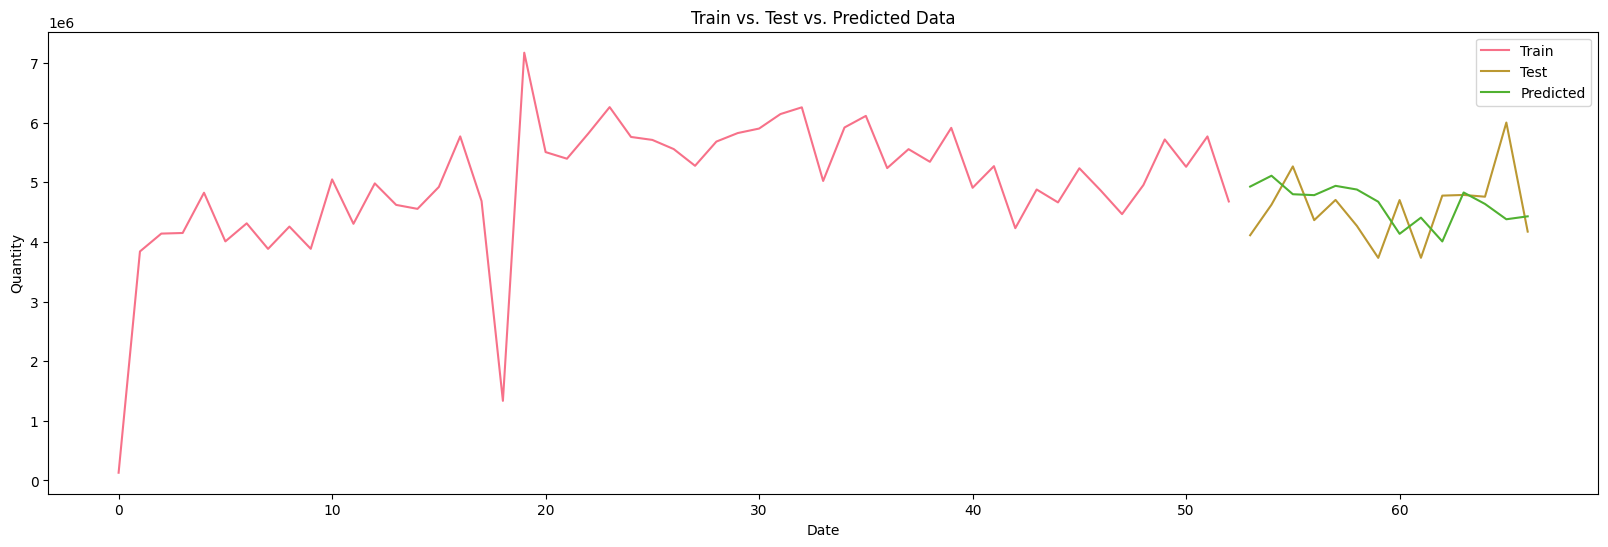

In [126]:
# Plot the train, test, and predicted data
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(test_data.index, predictions_sarimax, label='Predicted')
plt.title('Train vs. Test vs. Predicted Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [127]:
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data['quantity'], predictions_sarimax)

print('MAPE:', mape)

MAPE: 0.125793838332057


Evaluation for SARIMAX :
* Dapat diketahui dari visualisasi bahwa model ini memperlihatkan kinerja yang baik dimana pada predicted data mengikuti trend pada test data.
* Ditinjau dari error menggunakan mean absolute percentage error juga menunjukan angka yang kecil yaitu sebesar 0.126%
* dapat disimpulkan bahwa ARIMA dan SARIMAX mempunyai kinerja yang sama

# **`Holt-Winter`**

`Define Model`

In [132]:
# Build the Holt-Winters model with additive trend and seasonal components
model_hw = ExponentialSmoothing(train_data['quantity'], trend='add', seasonal='add', seasonal_periods=4) # seasonal period sudah ditinjau dari EDA

`Training`

In [133]:
# Fit the model to the data
fitted_model = model_hw.fit()

c:\Users\aldan\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


`Predict`

In [134]:
# Use the fitted model to make predictions on the test data
predictions_hw = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1])

## **`Evaluation for Holt-Winter`**

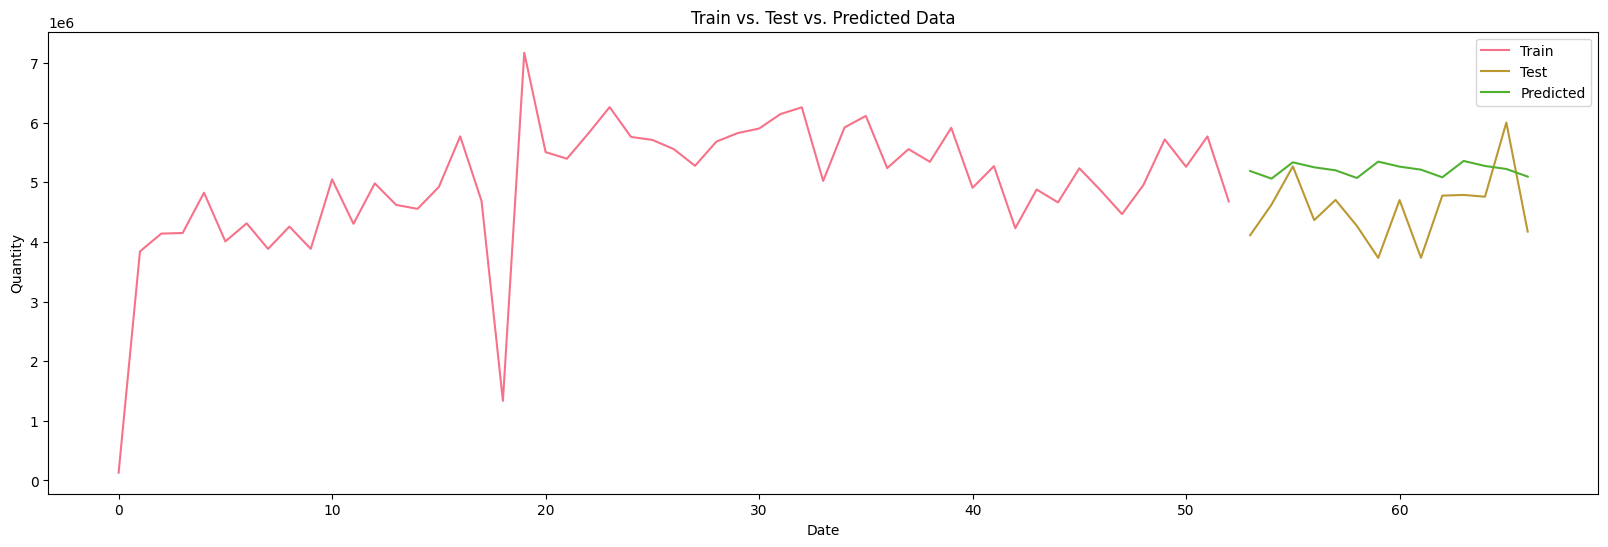

In [135]:
# Plot the train, test, and predicted data
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(test_data.index, predictions_hw, label='Predicted')
plt.title('Train vs. Test vs. Predicted Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [136]:
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data['quantity'], predictions_hw)

print('MAPE:', mape)

MAPE: 0.1754897733241247


Evaluation for Holt-Winter :
* Ditinjau dari error menggunakan mean absolute percentage error juga menunjukan angka yang kecil yaitu sebesar 0.175%
* Akan tetapi, Dapat diketahui dari visualisasi bahwa model ini memperlihatkan kinerja yang belum baik, karena hampir vanishing dimana tidak mengikuti trend pada data actual.

# **`USING LSTM`**

`Prepare datasets`

In [212]:
# Convert the 'week_end_date' column to a datetime object and set it as the index
df_lstm = df_main.copy()
df_lstm['week_end_date'] = pd.to_datetime(df_lstm['week_end_date'])
df_lstm.set_index('week_end_date', inplace=True)

In [213]:
# Split the data into training and testing sets
train_size = int(len(df_lstm) * 0.8)
train, test = df_lstm.iloc[:train_size], df_lstm.iloc[train_size:]

`Scaling`

In [214]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

`Function to Input`

In [215]:
# Define the function to create the input and output sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data)-sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

`Prepare Train Test to Input`

In [216]:
# Define the length of the input/output sequences
sequence_length = 5

# Create the training sequences
train_X, train_y = create_sequences(train_scaled, sequence_length)

# Create the testing sequences
test_X, test_y = create_sequences(test_scaled, sequence_length)

`Architecture Building`

In [217]:
# Define the model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

`Training`

In [218]:
# Train the model
history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
3/3 - 2s - loss: 0.3816 - val_loss: 0.2486 - 2s/epoch - 772ms/step
Epoch 2/100
3/3 - 0s - loss: 0.2985 - val_loss: 0.1881 - 58ms/epoch - 19ms/step
Epoch 3/100
3/3 - 0s - loss: 0.2253 - val_loss: 0.1354 - 63ms/epoch - 21ms/step
Epoch 4/100
3/3 - 0s - loss: 0.1616 - val_loss: 0.0907 - 61ms/epoch - 20ms/step
Epoch 5/100
3/3 - 0s - loss: 0.1076 - val_loss: 0.0546 - 59ms/epoch - 20ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0645 - val_loss: 0.0284 - 61ms/epoch - 20ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0339 - val_loss: 0.0134 - 67ms/epoch - 22ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0173 - val_loss: 0.0100 - 62ms/epoch - 21ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0142 - val_loss: 0.0152 - 59ms/epoch - 20ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0195 - val_loss: 0.0216 - 69ms/epoch - 23ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0241 - val_loss: 0.0227 - 62ms/epoch - 21ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0231 - val_loss: 0.0191 - 73ms/epoch - 24ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0188 -

`Predict`

In [219]:
# Generate predictions on the test data
test_predictions = model.predict(test_X)

1/1 [==============================] - 0s 433ms/step


`Unscaling`

In [220]:
# Unscale the predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions)
test_actual = scaler.inverse_transform(test_y.reshape(-1, 1))

## **`Evaluation for Baseline LSTM`**

In [222]:
# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_actual - test_predictions) / test_actual)) * 100
mape

13.236910515130232

Text(0, 0.5, 'Quantity')

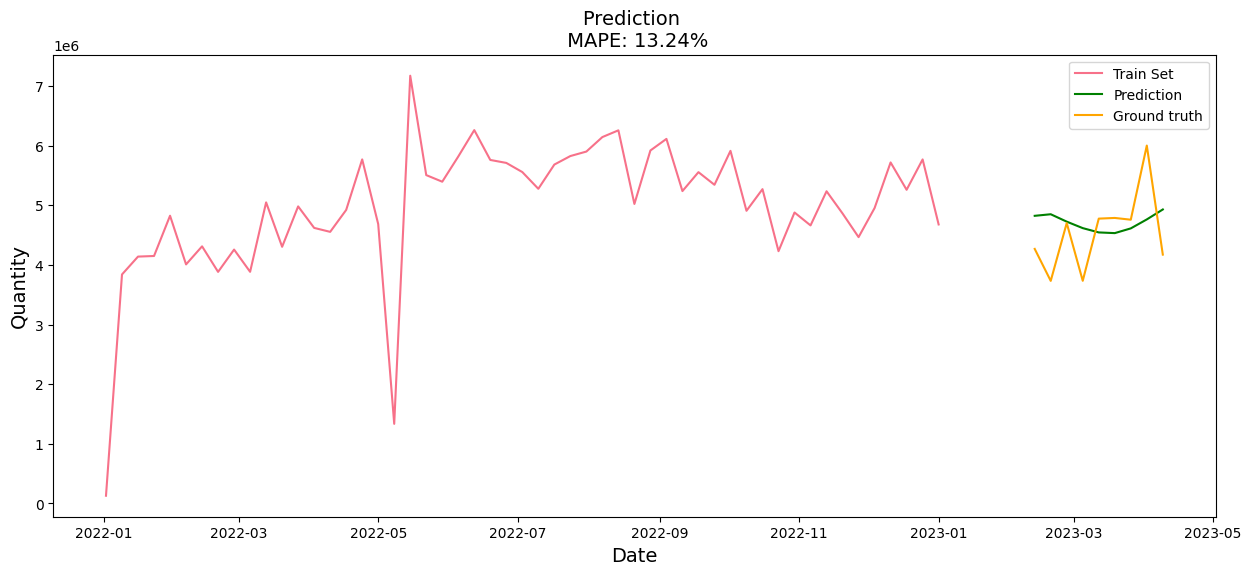

In [223]:
# Create ticks for the x-axis of the plot
x_train_ticks = train.index
x_test_ticks = test.index[sequence_length:]

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=train['quantity'], ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predictions[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_actual[:,0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAPE: {mape:.2f}%', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Quantity', fontsize=14)

Evaluation for Baseline LSTM:
* Ditinjau dari error menggunakan mean absolute percentage error juga menunjukan angka cukup besar dari yang lainnya yaitu sebesar 13.24%
* Pada visualisasi model mengikuti trend pada data actual akan tetapi model ini sangat jauh dari data actual

## **`Model Tuning LSTM`**

`Building new Architecture`

In [225]:
# Define the function to create the LSTM model
def create_model(units=50, dropout_rate=0.0, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model

`Tuning`

In [241]:
# Define the hyperparameters to search
param_dist = {
    'units': [32, 64, 128],
    'dropout_rate': [0.0, 0.2, 0.4],
    'optimizer': ['adam', 'rmsprop', 'sgd']
}

# Create the KerasRegressor wrapper for the model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Create the RandomizedSearchCV object
search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error')

# Fit the search object to the training data
search.fit(train_X, train_y)

# Print the best hyperparameters
print(search.best_params_)

C:\Users\aldan\AppData\Local\Temp\ipykernel_2392\3778379937.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


{'units': 128, 'optimizer': 'rmsprop', 'dropout_rate': 0.2}


In [242]:
# Create the final model with the best hyperparameters
best_model = create_model(**search.best_params_)

`Training`

In [243]:
# Train the model
history = best_model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
3/3 - 2s - loss: 0.4199 - val_loss: 0.1274 - 2s/epoch - 805ms/step
Epoch 2/100
3/3 - 0s - loss: 0.1205 - val_loss: 0.0232 - 62ms/epoch - 21ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0267 - val_loss: 0.0101 - 70ms/epoch - 23ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0148 - val_loss: 0.0101 - 72ms/epoch - 24ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0161 - val_loss: 0.0101 - 68ms/epoch - 23ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0162 - val_loss: 0.0109 - 67ms/epoch - 22ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0183 - val_loss: 0.0106 - 66ms/epoch - 22ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0147 - val_loss: 0.0110 - 71ms/epoch - 24ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0148 - val_loss: 0.0101 - 63ms/epoch - 21ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0140 - val_loss: 0.0105 - 63ms/epoch - 21ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0187 - val_loss: 0.0110 - 67ms/epoch - 22ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0156 - val_loss: 0.0103 - 64ms/epoch - 21ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0160 -

`Predict`

In [244]:
# Generate predictions on the test data
test_predictions = best_model.predict(test_X)

1/1 [==============================] - 0s 436ms/step


`Unscaling`

In [245]:
# Unscale the predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions)
test_actual = scaler.inverse_transform(test_y.reshape(-1, 1))

## `Evaluation For Tuned LSTM`

In [246]:
# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_actual - test_predictions) / test_actual)) * 100
print(f'Prediction \n MAPE: {mape:.2f}%')

Prediction 
 MAPE: 12.68%


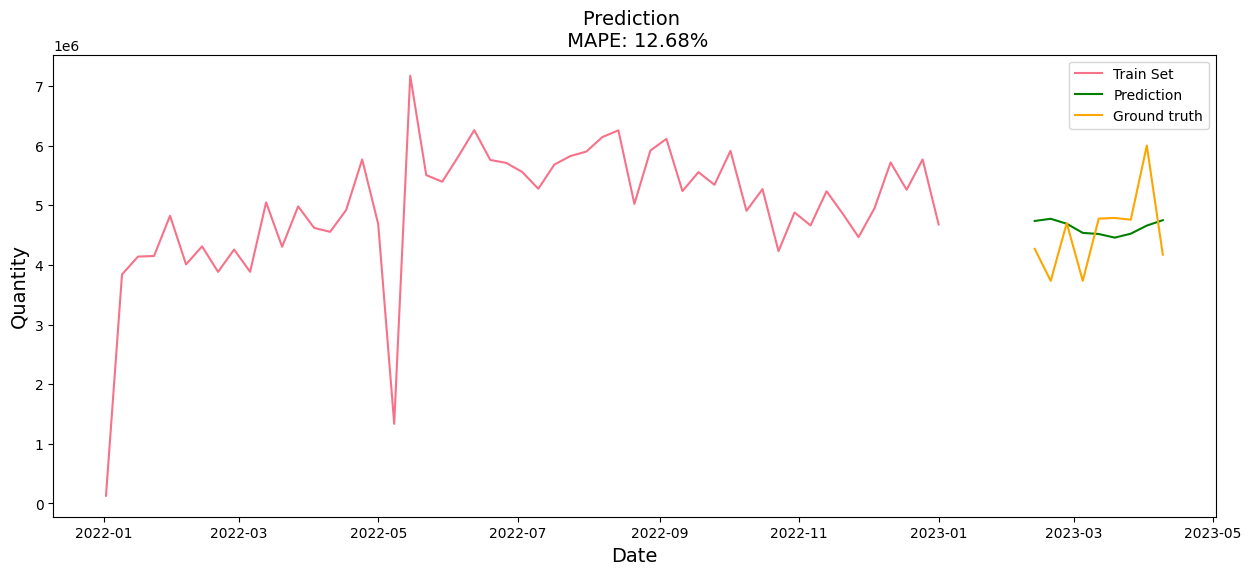

In [247]:
# Create ticks for the x-axis of the plot
x_train_ticks = train.index
x_test_ticks = test.index[sequence_length:]

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=train['quantity'], ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predictions[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_actual[:,0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAPE: {mape:.2f}%', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Quantity', fontsize=14)

plt.show()

Evaluation for Tuned LSTM:
* Error mengalami penurunan menjadi 12.68%
* AKan tetapi, model ini masih sangat jauh dari data actual

# **CONCLUSION THE BEST MODEL**

Dari semua training model diatas dapat disimpulkan model terbaik adalah `ARIMA` dan `SARIMAX`

Akan tetapi saya akan mengambil satu yaitu
* **ARIMA**
* Dikarenakan parameter yang digunakan pada ARIMA sudah semuanya ditinjau agar menggunakan order yang sesuai dari karakteristik dataset

## **FORECASTING 37 WEEKS (end of year) AHEAD**

In [ ]:
# Forecast 37 weeks ahead
n_forecast = 37
forecast_ar = fitted_model.forecast(steps=n_forecast)

# Create a dataframe to store the forecasted values
last_date = df_main['week_end_date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=n_forecast, freq='W')
forecast_df = pd.DataFrame({
    'week_end_date': forecast_dates,
    'quantity': forecast_ar
})

In [ ]:
# Concatenate the train and test data with the forecasted data
df_forecast = pd.concat([df_main, forecast_df])

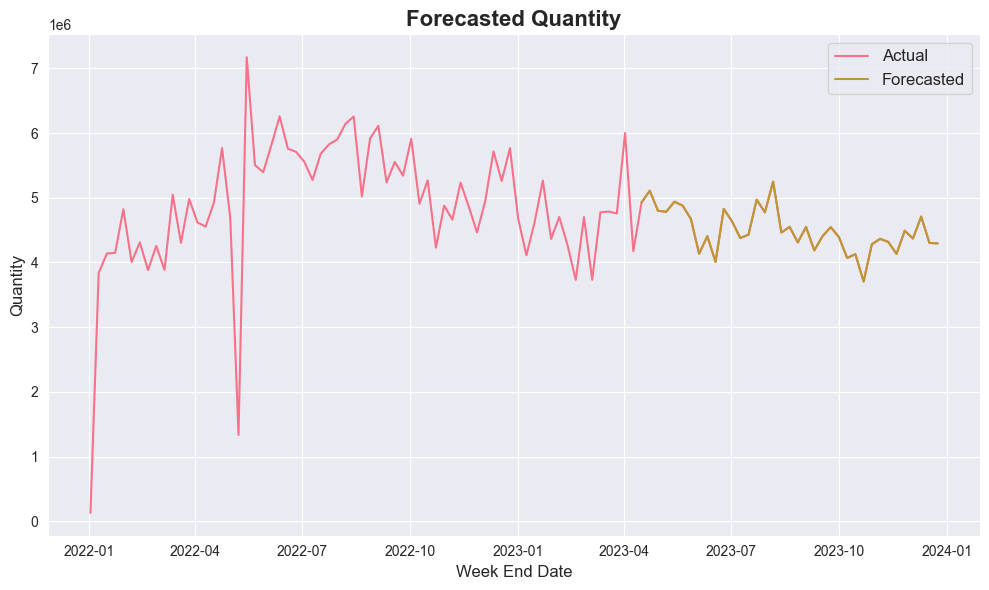

In [267]:
# Set the plot style
sns.set_style('darkgrid')

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original data and the forecasted values
sns.lineplot(data=df_forecast, x='week_end_date', y='quantity', ax=ax, label='Actual')
sns.lineplot(data=forecast_df, x='week_end_date', y='quantity', ax=ax, label='Forecasted')

# Set the title and axis labels
ax.set_title('Forecasted Quantity', fontsize=16, fontweight='bold')
ax.set_xlabel('Week End Date', fontsize=12)
ax.set_ylabel('Quantity', fontsize=12)

# Add a legend and adjust the layout
ax.legend(fontsize=12)
fig.tight_layout()

# Show the plot
plt.show()

Dapat dilihat dari Forecasting diatas bahwa akan terjadi sedikit penurunan pada penjualan keseluruhan product *ParagonCorp* dimana diawali pada sampai 2023 bulan ke-4 sampai bulan ke-5(bulan depan)

# **Forecasting Highlighted Product**

Pada sesi ini saya akan mem-forecast Top 3 product dengan penjualan terbanyak.

In [313]:
df_new = df[['week_end_date', 'product_item', 'quantity']]
df_new

,week_end_date,product_item,quantity
0,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119
...,...,...,...
102728,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920


In [425]:
# Group the data by product_item and sum the quantity for each item
top_3 = df.groupby('product_item')['quantity'].sum().reset_index().sort_values(ascending=False, by='quantity')[:3]
top_3

,product_item,quantity
409,2949ca4cfbf13969bccfbb9817f2526a,18206376
441,2db7ed9bd7573aec037aac59237cb3dd,9122007
213,160eb16a7369a645ec75caa3f14543d4,6771207


`Top 3 Highlighted Product (Penjualan Terbanyak pada dataset ini)`
1. 2949ca4cfbf13969bccfbb9817f2526a
2. 2db7ed9bd7573aec037aac59237cb3dd
3. 160eb16a7369a645ec75caa3f14543d4

In [372]:
# Find the top 3 items with the highest quantity
top_items = df_new.groupby("product_item")["quantity"].sum().nlargest(3).index.tolist()

# Forecast for each item
for item in top_items:
    # Get the data for this item
    data = df_new[df_new["product_item"] == item][["week_end_date", "quantity"]].set_index("week_end_date")

In [426]:
data

,quantity
week_end_date,
2022-01-02,866
2022-01-09,45415
2022-01-16,62469
2022-01-23,56122
2022-01-30,70807
...,...
2023-03-12,82267
2023-03-19,115918
2023-03-26,110645


`Check Stationarity`

In [373]:
check_stationarity(data['quantity'])

ADF Statistic: -4.264378
p-value: 0.000512
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591
Stationary


Dapat diketauhi bahwa data top 3 product ini sudah stationer bahwa bisa memenuhi asumsi ARIMA

`Forecasting`

Membuat model menggunakan parameter yang sama dengan trained data

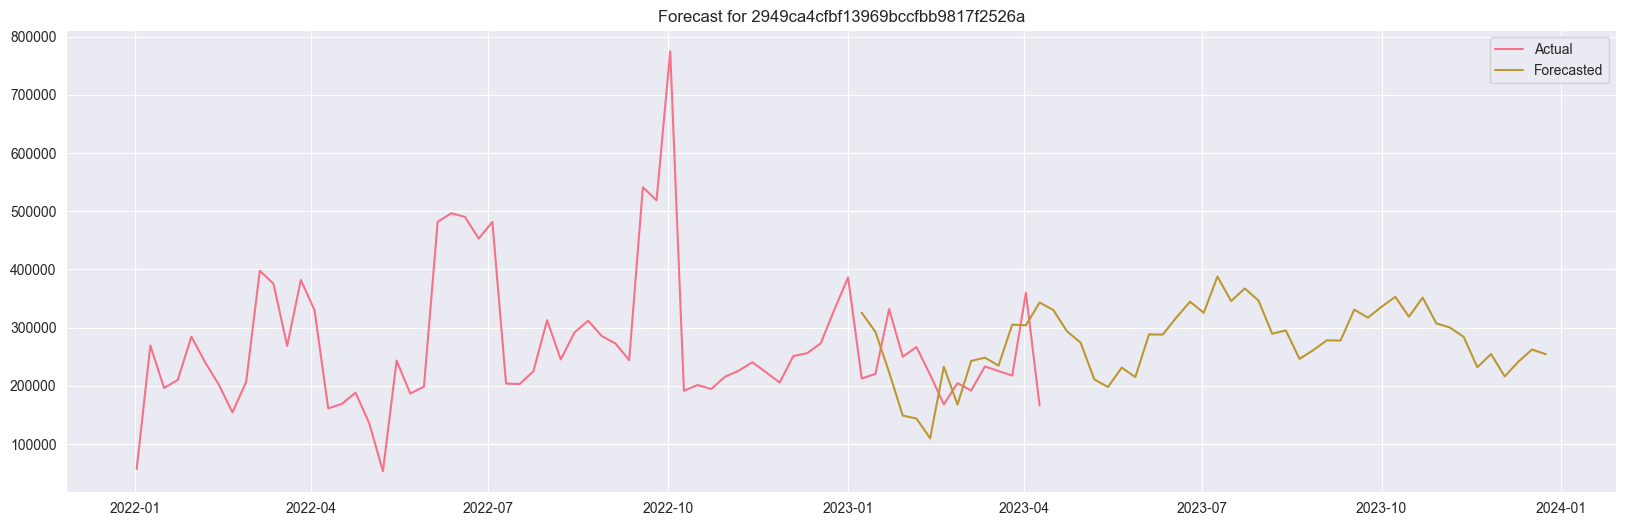

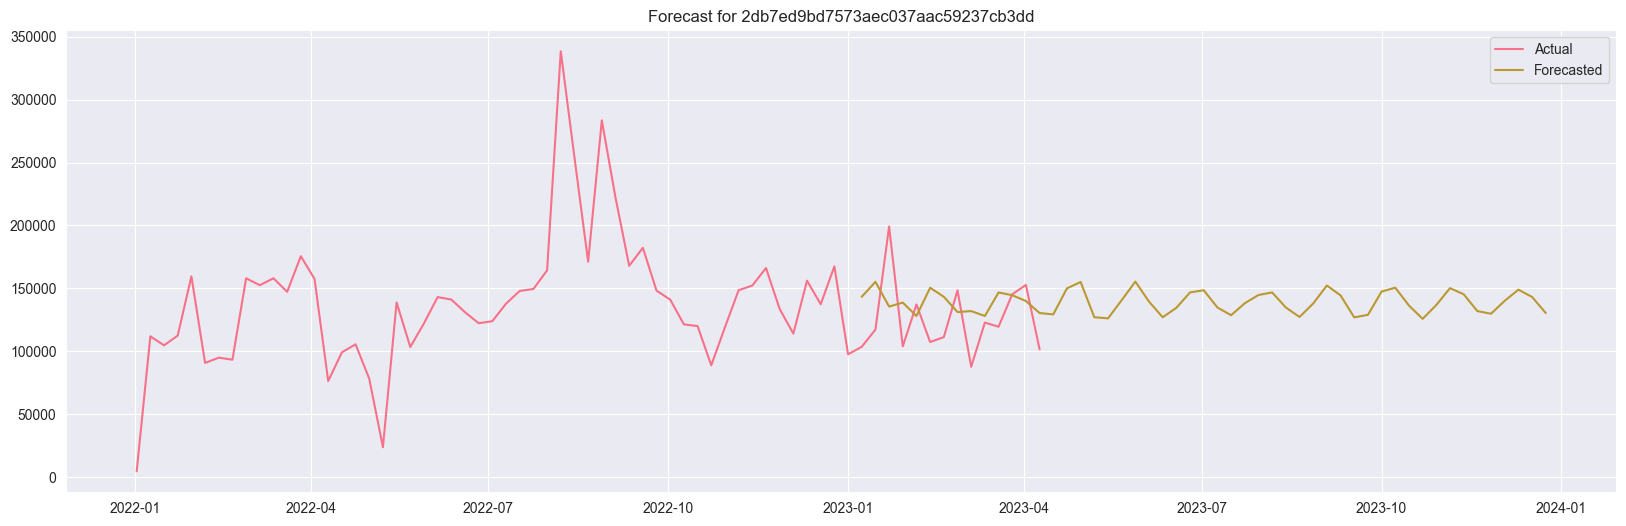

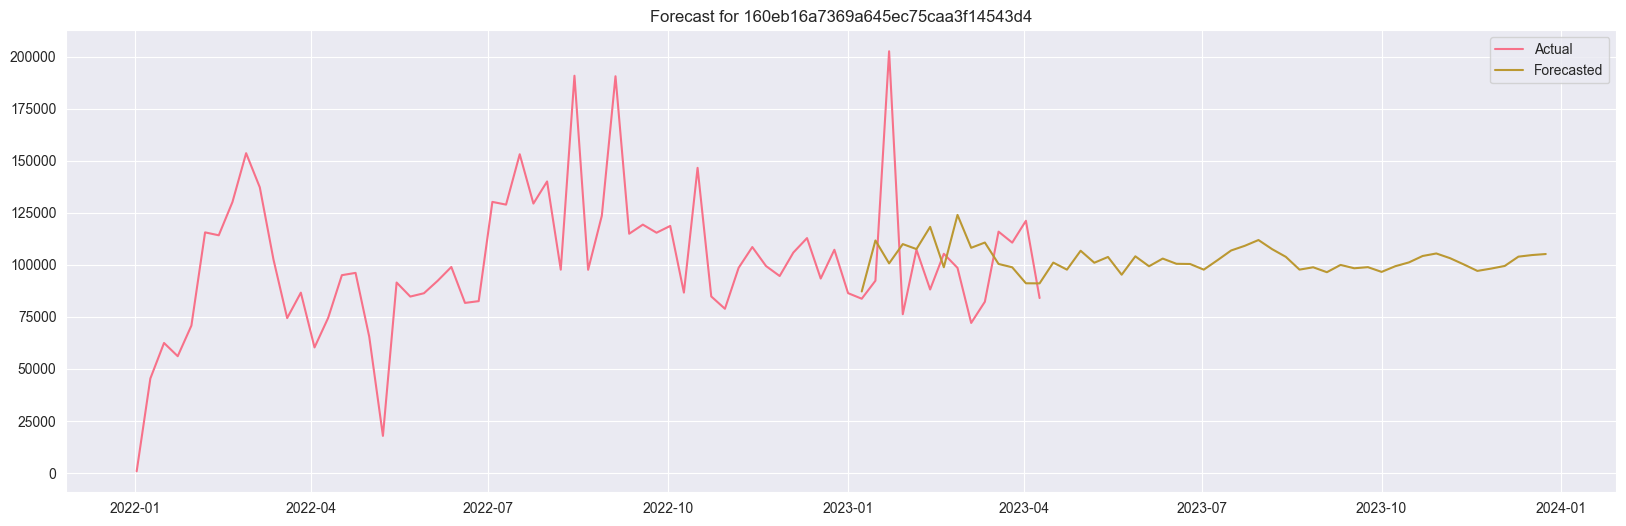

In [424]:
# Find the top 3 items with the highest quantity
top_items = df_new.groupby("product_item")["quantity"].sum().nlargest(3).index.tolist()

# Forecast for each item
for item in top_items:
    # Get the data for this item
    data = df_new[df_new["product_item"] == item][["week_end_date", "quantity"]].set_index("week_end_date")
    
    # Split the data into train and test sets
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Build the ARIMA model with (p,d,q) parameters = (19,1,3)
    model_ar = sm.tsa.ARIMA(train_data, order=(19,0,3))
    
    # Fit the model to the data
    fitted_model = model_ar.fit()
    
    # Use the fitted model to make predictions for the next 37 weeks
    start_date = test_data.index[0]
    end_date = test_data.index[-1] + pd.DateOffset(weeks=37)
    predictions_ar = fitted_model.predict(start=start_date, end=end_date, dynamic=True)
    
    # Plot the actual and forecasted values
    plt.plot(data.index, data["quantity"], label="Actual")
    plt.plot(predictions_ar.index, predictions_ar, label="Forecasted")
    plt.title(f"Forecast for {item}")
    plt.legend()
    plt.show()

Dapat dilihat dari visualisasi diatas bahwa yang mempunyai performa baik adalah product nomor 1, dimana diprediksi bahwa akan terjadi kenaikan pada bulan 5 sampai bulan 7 tahun 2023 lalu terjadi penurunan lagi pada selanjutnya

# **`OVERALL ANALYSIS`**

`Berdasarkan EDA`

* ParagonCorp Mempunyai dataset 67 minggu dari tahun awal 2022 sampai minggu ke 14 tahun 2023
* Penjualan mengalami penurunan drastis pada 2022-01-16 yang perlu di cek apa yang terjadi sebenarnya disana, Karena noise ini juga dapat menyebabkan peforma model yang kurang.
* Dari penurunan tersebut akan tetapi terjadi kenaikan lagi pada Minggu Sesudahnya. Ini bisa di cek kenapanya mungkin kebagian marketingnya. Jika mengalami kenaikan bisa di contoh untuk minggu-mingggu kedepannya agar bisa di pertahankan.
* Banyak sekali product yang di informasikan disini dari yang penjualannya tinggi sampai rendah sekali. Product2 yang mempunyai penjualan tinggi juga merupakan penggerak terjadinya kenaikan atau penurunan pada penjualan keseluruhan ini.

`Setelah Forecasting`

* Dapat dilihat dari Forecasting diatas bahwa akan terjadi sedikit penurunan pada penjualan keseluruhan product *ParagonCorp* dimana diawali pada sampai 2023 bulan ke-4 sampai bulan ke-5(bulan depan). Ini bisa dilakukan tindakan agar mengantisipasi terjadinya ini seperti melakukan treatment yang sama pada minggu2 terjadinya kenaikan penjualan.

Pada product2 yang memiliki penjualan tinggi.
* Product 2949ca4cfbf13969bccfbb9817f2526a yang mempunyai penjualan sebesar 18206376 pada 67 minggu terakhir ini juga mengalami penurunan pada bulan depan, Kemungkinan ini yang menyebabkan terjadinya penurunan pada keseluruhan penjualan.

`For Further Improvement`

* Kurangnya informasi marketing pada minggu2 yang terjadinya noise agar dapat dilakukan penjelasan analysis lebih dalam lagi.
* Menginformasikan semua product akan tetapi banyak product yang sangat rendah yang dapat disimpulkan kurangnya data untuk product tersebut, ini bisa menyebabkan bahwa product penjualan tinggi sangat mendominasi kepada keseluruhan penjualan.

In [427]:
# saving
with open('fitted_model_ar_finpro.pkl', 'wb') as file_1:
  joblib.dump(fitted_model, file_1)